In [1]:
# visuals

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR, ExponentialLR

import geoopt
from geoopt.optim import RiemannianAdam

from models import *
from losses import *
from utils import *
from trainer import MetricTrainer
from dataset import PariwiseDataset

In [3]:
cfg = dotdict()
cfg['bs'] = 512
cfg['lr'] = 1e-3
cfg['neg_samples'] = 10
cfg['embedding_dim'] = 256
cfg['margin'] = 0.5
cfg['lam'] = 10
cfg['step_size'] = 10
cfg['max_norm'] = 1
cfg['drop_rate'] = 0
cfg['weighted'] = False

In [4]:
DATA = 'samokat'
SIZE = '100k'

if DATA == 'movielens':
    data = load_data(f'ml-{SIZE}')
    data_train, data_valid, data_test = train_test_split_single(data, how='last')
elif DATA == 'samokat':
    data = pd.read_csv(f'data_{SIZE}.csv')
    data_train, data_valid, data_test = train_test_split_single(data, how='random')
    
N_USERS = data.user_id.nunique()
N_ITEMS = data.item_id.nunique()
user_sizes = data.groupby('user_id').count().item_id.to_numpy()
item_sizes = data.groupby('item_id').count().user_id.to_numpy()

In [5]:
train_set = PariwiseDataset(
    data_train, 
    N_USERS, 
    N_ITEMS, 
    neg_samples=cfg.neg_samples, 
    weights=(item_sizes if cfg.weighted else None))

valid_set = PariwiseDataset(data_valid, N_USERS, N_ITEMS, neg_samples=100)
test_set = PariwiseDataset(data_test, N_USERS, N_ITEMS, neg_samples=100)

#full_loader = DataLoader(full_set, batch_size=cfg.bs, shuffle=True)
train_loader = DataLoader(train_set, batch_size=cfg.bs, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=N_USERS, shuffle=False)
test_loader = DataLoader(test_set, batch_size=N_USERS, shuffle=False)

In [6]:
metric_model = CML(N_USERS, N_ITEMS, embedding_dim=cfg.embedding_dim, dropout_rate=cfg.drop_rate, max_norm=cfg.max_norm)
# metric_criterion = nn.TripletMarginLoss(margin=1)
metric_criterion = AdditiveLoss(
    nn.TripletMarginLoss(margin=cfg.margin),
    CovarianceLoss(),
    coefficients=[1, cfg.lam]
)

In [7]:
metric_trainer = MetricTrainer(metric_model, metric_criterion)
metric_trainer.optimizer = Adam(metric_trainer.model.parameters(), lr=cfg.lr)

In [8]:
metric_trainer.fit(train_loader, valid_loader, epochs=50, plot=False)

  0%|          | 0/50 [00:00<?, ?it/s]

epoch: 1


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.41939967574249387


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.35491296648979187
valid_hitrate: 1052/2447
valid_ndcg: 566.86/2447
--------------------------------------------------------------------------------
epoch: 2


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.29751068384859575


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.317008912563324
valid_hitrate: 1055/2447
valid_ndcg: 541.93/2447
--------------------------------------------------------------------------------
epoch: 3


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.2577345319755414


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.30369293689727783
valid_hitrate: 1088/2447
valid_ndcg: 573.25/2447
--------------------------------------------------------------------------------
epoch: 4


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.23568061009751565


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.29534366726875305
valid_hitrate: 1121/2447
valid_ndcg: 613.36/2447
--------------------------------------------------------------------------------
epoch: 5


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.2165723999289318


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.2874131202697754
valid_hitrate: 1153/2447
valid_ndcg: 637.59/2447
--------------------------------------------------------------------------------
epoch: 6


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.1989864342655811


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.27842244505882263
valid_hitrate: 1183/2447
valid_ndcg: 659.29/2447
--------------------------------------------------------------------------------
epoch: 7


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.18489294557671274


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.2708314061164856
valid_hitrate: 1229/2447
valid_ndcg: 677.89/2447
--------------------------------------------------------------------------------
epoch: 8


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.17397443240225627


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.2650613784790039
valid_hitrate: 1255/2447
valid_ndcg: 704.59/2447
--------------------------------------------------------------------------------
epoch: 9


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.1665444386567121


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.26017165184020996
valid_hitrate: 1273/2447
valid_ndcg: 710.99/2447
--------------------------------------------------------------------------------
epoch: 10


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.16133644716589862


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.2570016086101532
valid_hitrate: 1291/2447
valid_ndcg: 723.34/2447
--------------------------------------------------------------------------------
epoch: 11


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.15759080749843757


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.2547553777694702
valid_hitrate: 1319/2447
valid_ndcg: 753.64/2447
--------------------------------------------------------------------------------
epoch: 12


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.15523529193164165


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.25249558687210083
valid_hitrate: 1311/2447
valid_ndcg: 741.13/2447
--------------------------------------------------------------------------------
epoch: 13


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.1533825175924451


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.25134244561195374
valid_hitrate: 1323/2447
valid_ndcg: 740.96/2447
--------------------------------------------------------------------------------
epoch: 14


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.15265163279952804


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.250102162361145
valid_hitrate: 1329/2447
valid_ndcg: 748.65/2447
--------------------------------------------------------------------------------
epoch: 15


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.15137924644023337


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.24826514720916748
valid_hitrate: 1354/2447
valid_ndcg: 764.42/2447
--------------------------------------------------------------------------------
epoch: 16


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.1510164162719437


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.24701739847660065
valid_hitrate: 1329/2447
valid_ndcg: 753.2/2447
--------------------------------------------------------------------------------
epoch: 17


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.15041799141162354


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.24485136568546295
valid_hitrate: 1321/2447
valid_ndcg: 751.75/2447
--------------------------------------------------------------------------------
epoch: 18


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.15010787086337024


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.24541327357292175
valid_hitrate: 1339/2447
valid_ndcg: 759.12/2447
--------------------------------------------------------------------------------
epoch: 19


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.14990459772616782


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.2447471171617508
valid_hitrate: 1347/2447
valid_ndcg: 761.84/2447
--------------------------------------------------------------------------------
epoch: 20


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.14951971625782431


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.2433425635099411
valid_hitrate: 1345/2447
valid_ndcg: 761.79/2447
--------------------------------------------------------------------------------
epoch: 21


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.14937705332071993


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.24203690886497498
valid_hitrate: 1362/2447
valid_ndcg: 772.03/2447
--------------------------------------------------------------------------------
epoch: 22


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.14906825780556465


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.24191443622112274
valid_hitrate: 1343/2447
valid_ndcg: 764.6/2447
--------------------------------------------------------------------------------
epoch: 23


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.14882179447181562


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.24093276262283325
valid_hitrate: 1379/2447
valid_ndcg: 782.2/2447
--------------------------------------------------------------------------------
epoch: 24


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.14888907703741683


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.24082042276859283
valid_hitrate: 1375/2447
valid_ndcg: 793.12/2447
--------------------------------------------------------------------------------
epoch: 25


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.1487442026431648


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.24053458869457245
valid_hitrate: 1368/2447
valid_ndcg: 781.42/2447
--------------------------------------------------------------------------------
epoch: 26


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.14879638526140082


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.2417665719985962
valid_hitrate: 1379/2447
valid_ndcg: 776.91/2447
--------------------------------------------------------------------------------
epoch: 27


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.14877379205838548


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.24046926200389862
valid_hitrate: 1386/2447
valid_ndcg: 790.34/2447
--------------------------------------------------------------------------------
epoch: 28


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.1487784916973863


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.24033083021640778
valid_hitrate: 1373/2447
valid_ndcg: 783.84/2447
--------------------------------------------------------------------------------
epoch: 29


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.14845041977485438


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.24028019607067108
valid_hitrate: 1374/2447
valid_ndcg: 789.6/2447
--------------------------------------------------------------------------------
epoch: 30


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.1483160216770871


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.23955558240413666
valid_hitrate: 1365/2447
valid_ndcg: 773.63/2447
--------------------------------------------------------------------------------
epoch: 31


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.14829064905643463


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.23951441049575806
valid_hitrate: 1356/2447
valid_ndcg: 777.09/2447
--------------------------------------------------------------------------------
epoch: 32


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.14824892993996905


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.24005591869354248
valid_hitrate: 1370/2447
valid_ndcg: 771.27/2447
--------------------------------------------------------------------------------
epoch: 33


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.14816033746559581


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.2387390285730362
valid_hitrate: 1379/2447
valid_ndcg: 787.33/2447
--------------------------------------------------------------------------------
epoch: 34


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.1481474277548765


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.23799407482147217
valid_hitrate: 1375/2447
valid_ndcg: 784.22/2447
--------------------------------------------------------------------------------
epoch: 35


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.14806985160755237


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.23875349760055542
valid_hitrate: 1362/2447
valid_ndcg: 778.82/2447
--------------------------------------------------------------------------------
epoch: 36


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.1480801524448145


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.23885294795036316
valid_hitrate: 1389/2447
valid_ndcg: 783.23/2447
--------------------------------------------------------------------------------
epoch: 37


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.14790555436885794


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.2391606867313385
valid_hitrate: 1374/2447
valid_ndcg: 789.33/2447
--------------------------------------------------------------------------------
epoch: 38


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.14769959496577997


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.23835554718971252
valid_hitrate: 1370/2447
valid_ndcg: 784.25/2447
--------------------------------------------------------------------------------
epoch: 39


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.14838945335118559


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.2389506846666336
valid_hitrate: 1369/2447
valid_ndcg: 782.39/2447
--------------------------------------------------------------------------------
epoch: 40


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.1479961015479103


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.2383163869380951
valid_hitrate: 1370/2447
valid_ndcg: 784.27/2447
--------------------------------------------------------------------------------
epoch: 41


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.14786962665500442


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.23756510019302368
valid_hitrate: 1370/2447
valid_ndcg: 783.0/2447
--------------------------------------------------------------------------------
epoch: 42


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.14766956616134544


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.23789694905281067
valid_hitrate: 1383/2447
valid_ndcg: 791.64/2447
--------------------------------------------------------------------------------
epoch: 43


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.14789587118862813


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.23814891278743744
valid_hitrate: 1368/2447
valid_ndcg: 776.46/2447
--------------------------------------------------------------------------------
epoch: 44


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.1477614636508582


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.2376013547182083
valid_hitrate: 1377/2447
valid_ndcg: 790.75/2447
--------------------------------------------------------------------------------
epoch: 45


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.14799458420401468


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.23885910212993622
valid_hitrate: 1367/2447
valid_ndcg: 785.36/2447
--------------------------------------------------------------------------------
epoch: 46


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.14796091241674272


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.238690584897995
valid_hitrate: 1371/2447
valid_ndcg: 785.76/2447
--------------------------------------------------------------------------------
epoch: 47


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.14774692198993022


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.2380852997303009
valid_hitrate: 1363/2447
valid_ndcg: 779.5/2447
--------------------------------------------------------------------------------
epoch: 48


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.1477341735394213


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.23803582787513733
valid_hitrate: 1367/2447
valid_ndcg: 779.3/2447
--------------------------------------------------------------------------------
epoch: 49


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.14791023633711


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.237844318151474
valid_hitrate: 1376/2447
valid_ndcg: 788.9/2447
--------------------------------------------------------------------------------
epoch: 50


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 0.14739788191012687


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 0.23788350820541382
valid_hitrate: 1381/2447
valid_ndcg: 789.03/2447
--------------------------------------------------------------------------------


In [9]:
user_emb, item_emb = metric_trainer.predict_embeddings(project_onto_euclidean=False)
emb = torch.cat([user_emb.cpu(), item_emb.cpu()], dim=0)

In [10]:
from umap.umap_ import UMAP

In [11]:
umap_emb = UMAP(metric='euclidean', n_neighbors=30).fit_transform(emb)
umap_user_emb, umap_item_emb = umap_emb[:metric_trainer.model.n_user, :], umap_emb[metric_trainer.model.n_user:, :]

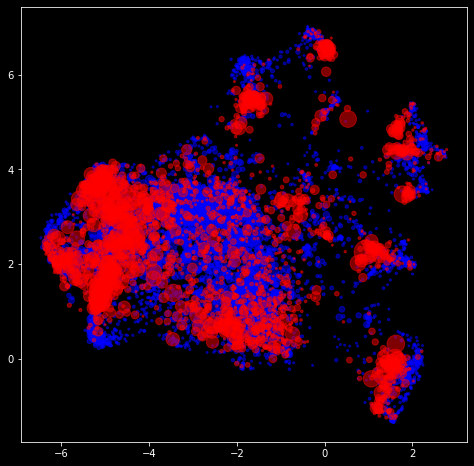

In [12]:
with plt.style.context('dark_background'):
    fig = plt.figure(figsize=(8,8))
    plt.scatter(umap_item_emb[:, 0], umap_item_emb[:, 1], s=item_sizes, alpha=0.5, color='blue') # items
    plt.scatter(umap_user_emb[:, 0], umap_user_emb[:, 1], s=user_sizes, alpha=0.5, color='red') # users
plt.show()

In [13]:
metric_trainer.plot_embeddings(algorithm='umap', item_sizes=item_sizes, user_sizes=user_sizes)

NameError: name 'tsne_item_emb' is not defined

<Figure size 576x576 with 0 Axes>